In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [5]:
df = pd.read_csv('../Filip/processed-data.csv')

df.head()

,ownership,papan_pencatatan,IPO Raised Fund,float,price_cat,lead_underwriter,underwriter_freq_cat,underwriter_avg_aset_cat,avg_last3_weighted_1dpct,avg_last3_weighted_1wpct,...,1d_pct,1w_pct,1m_pct,6m_pct,1y_pct,1d,1w,1m,6m,1y
0,2,4,24.290267,0.0956,1,38,2,0,NaN,NaN,...,0,1,1,0,0,0,1,1,0,0
1,1,3,28.658473,0.1500,3,3,2,2,NaN,NaN,...,2,0,0,0,0,2,0,0,0,0
2,2,2,27.150335,0.1500,3,2,1,1,NaN,NaN,...,0,0,0,1,1,0,0,0,1,1
3,1,4,26.081580,0.0726,3,10,2,1,NaN,NaN,...,0,1,1,1,1,0,1,1,1,1
4,2,3,24.635289,0.2500,0,38,2,0,1.0,1.0,...,0,1,1,1,1,0,1,1,1,1


In [199]:
feature_cols = [
    'lead_underwriter', 'underwriter_freq_cat', 'underwriter_avg_aset_cat',
    'ownership', 'papan_pencatatan', 'price_cat',
    'float', 'total_aset_cat', 'leverage_ratio', 
    'turnover_ratio', 'return_on_equity','avg_last3_weighted_1mpct',   
]

X = df[feature_cols].apply(LabelEncoder().fit_transform)
y = df['1y']

mask = y != 2
X = X[mask]
y = y[mask]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [200]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
weight_dict = dict(zip(np.unique(y), weights))

weight_dict

{0: 0.8109243697478992, 1: 1.304054054054054}

In [201]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier

catboost_model = CalibratedClassifierCV(
    estimator=CatBoostClassifier(
        iterations=500,
        learning_rate=0.03,
        depth=5,
        l2_leaf_reg=10,
        loss_function='Logloss',
        auto_class_weights='Balanced',
        verbose=0,
        random_state=42
    ),
    method='isotonic',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
)

In [202]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42
)

In [203]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=weights[1] / weights[0],
    random_state=42,
    reg_alpha=0.1
)


In [204]:
from sklearn.ensemble import VotingClassifier


ensemble_model = VotingClassifier(
    estimators=[
        ('cat', catboost_model),
        ('rf',  rf_model),
        ('xgb', xgb_model)
    ],
    voting='soft',
    weights=[3, 1, 2]
)

ensemble_model.fit(X_train, y_train)

VotingClassifier(estimators=[('cat',
                              CalibratedClassifierCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                                                     estimator=<catboost.core.CatBoostClassifier object at 0x00000176A64131D0>,
                                                     method='isotonic')),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     min_samples_split=5,
                                                     n_estimators=300,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.05, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=300, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                 voting='soft', weights=[3, 1, 2])

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.57      0.63        23
           1       0.52      0.69      0.59        16

    accuracy                           0.62        39
   macro avg       0.62      0.63      0.61        39
weighted avg       0.64      0.62      0.62        39



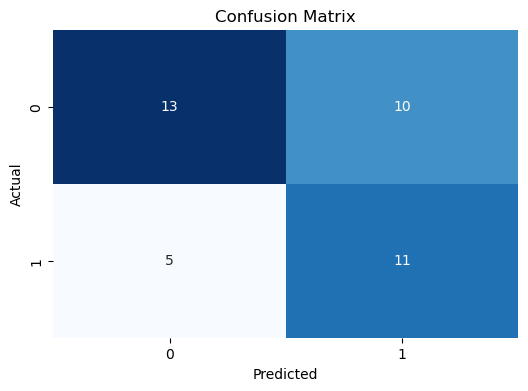

In [205]:
probs = ensemble_model.predict_proba(X_test)[:, 1]
y_pred = (probs > 0.44).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [206]:
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict

thresholds = np.arange(0.3, 0.61, 0.01)
f1_scores = []

probs = cross_val_predict(
    ensemble_model,
    X, y,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    method='predict_proba'
)[:, 1]

for t in thresholds:
    preds = (probs >= t).astype(int)
    score = f1_score(y, preds, average='macro')
    f1_scores.append(score)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1 Macro Score: {best_f1:.4f}")


Best Threshold: 0.44
Best F1 Macro Score: 0.6612


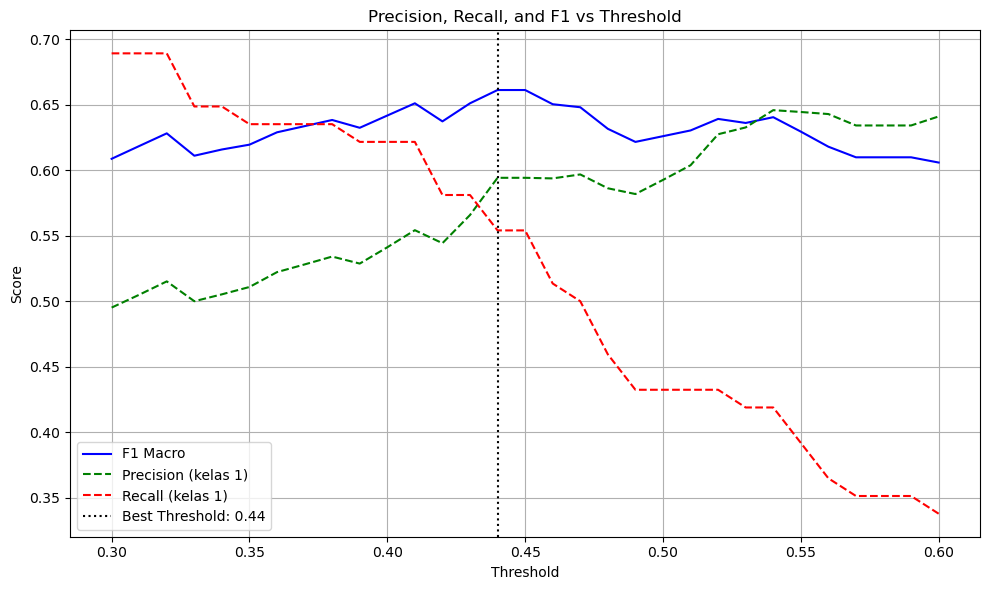

In [207]:
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

precisions = []
recalls = []

for t in thresholds:
    preds = (probs >= t).astype(int)
    precisions.append(precision_score(y, preds))
    recalls.append(recall_score(y, preds))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Macro', color='blue')
plt.plot(thresholds, precisions, label='Precision (kelas 1)', linestyle='--', color='green')
plt.plot(thresholds, recalls, label='Recall (kelas 1)', linestyle='--', color='red')
plt.axvline(best_threshold, linestyle=':', color='black', label=f'Best Threshold: {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


F1 Score (threshold=0.4400000000000001): 0.6612
Accuracy: 0.6839378238341969


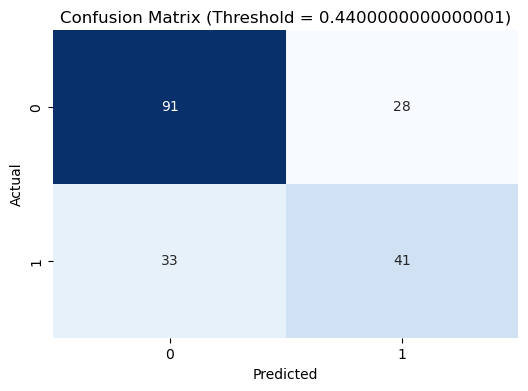

In [208]:
probs = cross_val_predict(ensemble_model, X, y, 
                          cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                          method='predict_proba')[:, 1]

threshold = best_threshold
preds = (probs >= threshold).astype(int)

cm = confusion_matrix(y, preds)
print(f"F1 Score (threshold={threshold}): {f1_score(y, preds, average='macro'):.4f}")
print(f"Accuracy: {accuracy_score(y, preds)}")

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.show()